In [1]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def integrand(args):
    #return -(args[0]-3)**2+5
    #return 1/(args[0]-3)**2
    #return 10*np.exp(-(1/0.01)*(args[0]-3)**2)
    return np.exp(-(500)*((args[0]-2)**2)*(args[1]-2)**2) + np.exp(-(500)*((args[0]-4)**2)*(args[1]-4)**2)

In [3]:
from typing import Callable, Iterable, List

class dist_conv:
    def __init__(self, integrand:Callable, dims:int, boundaries:List[List[float]], bins_per_dim:int=10):        
        self.integrand = integrand
        self.dims = dims
        self.boundaries = boundaries
        self.bins_per_dim = bins_per_dim
        
        bin_bounds = []
        self.adapted = False

        for i in range(dims):
            boundary_arr = []
            c_cur = boundaries[i][0]
            c_step = (boundaries[i][1] - boundaries[i][0])/bins_per_dim
            
            for j in range(bins_per_dim):
                boundary_arr.append([c_cur, c_cur + c_step])
                c_cur += c_step
            
            #bin_weights.append(np.ones(bins_per_dim, dtype=float) * 1/bins_per_dim)
            #bin_weights.append(1/bins_per_dim)
            bin_bounds.append(boundary_arr)
    
        # n_hyper_cubes = bins_per_dims**dims
        
        self.bin_indices = np.arange(bins_per_dim)
        self.bin_bounds = np.array(bin_bounds)
        
    # Generate
    def importance_per_dim(self, dim:int):
        bins = self.bin_bounds[dim][:].T
        diffs = bins[1] - bins[0]
        importance_per_dim = ((1/self.bins_per_dim))*1/diffs # (self.boundaries[dim][1] - self.boundaries[dim][0])/diffs
        
        return importance_per_dim
    
    def sample(self, n_samples:int=1, with_importance:bool=False):
        samples = []
        importance = []
        
        for i in range(self.dims):
            bin_idx = np.random.choice(self.bin_indices, size=n_samples)
            bins = self.bin_bounds[i][bin_idx].T
            
            samples_per_dim = np.random.uniform(low=bins[0], high=bins[1])
            samples.append(samples_per_dim)
            
            if with_importance:
                diffs = bins[1] - bins[0]
                importance_per_dim = ((1/self.bins_per_dim))*1/diffs # (self.boundaries[i][1] - self.boundaries[i][0])/diffs
                importance.append(importance_per_dim)

        if with_importance:
            return np.array(samples), np.prod(importance, axis=0)
        else:
            return np.array(samples)
    
    # Adapt
    def learn(self, n_samples:int=1000000):
        self.adapted = True
        
        samples = self.sample(n_samples)
        results = self.integrand(samples)
        
        for j in range(self.dims):
            # surface per dim and bin
            k = 0 #bin_lower = 0

            sort_mask = np.argsort(samples[j])
            samples_per_dim = samples[j][sort_mask]
            results_per_dim = results[sort_mask]
            bounds_per_dim = self.boundaries[j]
            
            surf = np.trapz(results_per_dim, x=samples_per_dim)
            surf_per_bin = surf/self.bins_per_dim
            
            bin_vals = []
            
            for i in range(self.bins_per_dim):
                running_sum = 0
                k0 = k
                while running_sum < surf_per_bin and k < n_samples - 1:
                    running_sum += results_per_dim[k]*(
                        (samples_per_dim[k+1] if k > 0 else bounds_per_dim[1]) - 
                        (samples_per_dim[k] if k <= n_samples-1 else bounds_per_dim[0]) )
                    k += 1
                
                bin_vals.append([
                    self.boundaries[j][0] if i == 0 else samples_per_dim[k0],
                    self.boundaries[j][1] if i == self.bins_per_dim-1 else samples_per_dim[k]])
                
                #print(f"{k0}-{k} : {bin_vals[-1][0]}-{bin_vals[-1][1]}")
                
            self.bin_bounds[j] = bin_vals
    
    # Integrate
    def integrate(self, n_samples:int=10000):
        samples, importance = self.sample(n_samples, with_importance=True)
        results = self.integrand(samples)
        
        V = 1
        for j in range(self.dims):
            V = V*(self.boundaries[j][1] - self.boundaries[j][0])
                
        if False:#not self.adapted:
            res = results.sum()/n_samples
                
            return res*V
        else:
            f = results
            p = 1/V
            q = importance/V
            
            #print("p", p)
            #print("p/q", p/q)
            #print("f", f)
            #print("q", q)
            
            res = np.sum(f*p/q).sum()/n_samples
            
            # p/q != 
            
            return res

# 1D example

In [596]:
def integrand_1d(args):
    #return -(args[0]-3)**2+5
    #return 1/(args[0]-3)**2
    #return 10*np.exp(-(1/0.01)*(args[0]-3)**2)
    return np.exp(-3*((args[0]-3)**2))

dims = 1
bins_per_dim = 30
boundaries = [
    [0., 6.]
]
instance = dist_conv(integrand_1d, dims, boundaries, bins_per_dim=bins_per_dim)

In [597]:
print(instance.integrate(10000), np.sum(instance.importance_per_dim(0)))

1.005258448843808 4.9999999999999964


(array([0.16890491, 0.17090497, 0.1652548 , 0.16340475, 0.16435478,
        0.16840489, 0.16800488, 0.16140469, 0.16715486, 0.16800488,
        0.16495479, 0.17000494, 0.16730486, 0.16445478, 0.16915491,
        0.16350475, 0.17040495, 0.16915491, 0.16605482, 0.1653548 ,
        0.16565481, 0.16795488, 0.16580482, 0.16560481, 0.1651548 ,
        0.16995494, 0.16010465, 0.17085496, 0.16275473, 0.17015494]),
 array([1.51208335e-04, 2.00145397e-01, 4.00139586e-01, 6.00133775e-01,
        8.00127964e-01, 1.00012215e+00, 1.20011634e+00, 1.40011053e+00,
        1.60010472e+00, 1.80009891e+00, 2.00009310e+00, 2.20008729e+00,
        2.40008148e+00, 2.60007566e+00, 2.80006985e+00, 3.00006404e+00,
        3.20005823e+00, 3.40005242e+00, 3.60004661e+00, 3.80004080e+00,
        4.00003499e+00, 4.20002918e+00, 4.40002336e+00, 4.60001755e+00,
        4.80001174e+00, 5.00000593e+00, 5.20000012e+00, 5.39999431e+00,
        5.59998850e+00, 5.79998269e+00, 5.99997688e+00]),
 <BarContainer object of 30 

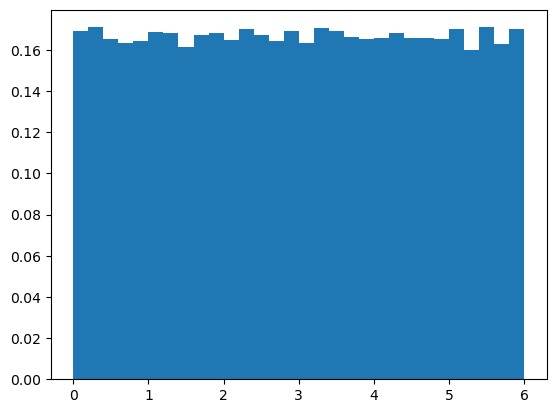

In [548]:
n_samples = 100000
samples = instance.sample(n_samples)
plt.hist(samples[0], density=True, bins=bins_per_dim)
# sns.scatterplot(x=samples[0], y=integrand(samples))

In [549]:
instance.learn()

0-375484 : 0.0-2.251315517540625
375484-398095 : 2.251315517540625-2.3871990153765923
398095-413159 : 2.3871990153765923-2.47682367101077
413159-424856 : 2.47682367101077-2.5465478070305574
424856-434698 : 2.5465478070305574-2.605076926260825
434698-443179 : 2.605076926260825-2.65643635129589
443179-451078 : 2.65643635129589-2.7028717523476287
451078-458310 : 2.7028717523476287-2.7457391663614734
458310-464996 : 2.7457391663614734-2.7859612754290786
464996-471337 : 2.7859612754290786-2.824204659176159
471337-477392 : 2.824204659176159-2.8609604414264975
477392-483332 : 2.8609604414264975-2.896620434050177
483332-489077 : 2.896620434050177-2.9315165795721483
489077-494801 : 2.9315165795721483-2.9659155075349424
494801-500473 : 2.9659155075349424-3.0000709083352572
500473-506195 : 3.0000709083352572-3.0342407552574335
506195-511910 : 3.0342407552574335-3.0686354074864832
511910-517692 : 3.0686354074864832-3.103529385977066
517692-523546 : 3.103529385977066-3.1391935004319946
523546-52953

(array([0.01490419, 0.01545435, 0.01475415, 0.01585446, 0.01485418,
        0.01395393, 0.01425401, 0.01430402, 0.01455409, 0.01525429,
        0.01530431, 0.19410461, 0.47068243, 0.73415656, 0.94416565,
        0.93101195, 0.74305906, 0.46338037, 0.19055361, 0.01515426,
        0.01505424, 0.01605452, 0.01520428, 0.01425401, 0.01495421,
        0.01550436, 0.01495421, 0.01530431, 0.01595449, 0.01445407]),
 array([1.66242750e-03, 2.01606156e-01, 4.01549885e-01, 6.01493614e-01,
        8.01437343e-01, 1.00138107e+00, 1.20132480e+00, 1.40126853e+00,
        1.60121226e+00, 1.80115599e+00, 2.00109972e+00, 2.20104344e+00,
        2.40098717e+00, 2.60093090e+00, 2.80087463e+00, 3.00081836e+00,
        3.20076209e+00, 3.40070582e+00, 3.60064955e+00, 3.80059328e+00,
        4.00053700e+00, 4.20048073e+00, 4.40042446e+00, 4.60036819e+00,
        4.80031192e+00, 5.00025565e+00, 5.20019938e+00, 5.40014311e+00,
        5.60008683e+00, 5.80003056e+00, 5.99997429e+00]),
 <BarContainer object of 30 

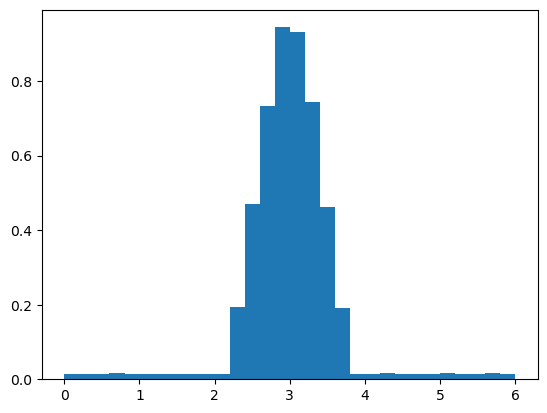

In [550]:
n_samples = 100000
samples = instance.sample(n_samples)
plt.hist(samples[0], density=True, bins=bins_per_dim)
# sns.scatterplot(x=samples[0], y=integrand(samples))

In [551]:
print(instance.integrate(10000), np.sum(instance.importance_per_dim(0)))

p 0.16666666666666666
p/q [4.0851762  1.75655719 1.1028623  ... 2.09313973 1.5415991  4.07650494]
f [0.2697312  0.53948126 0.91595677 ... 0.46968644 0.63825723 0.21200218]
q [0.04079791 0.09488257 0.15112192 ... 0.0796252  0.10811285 0.0408847 ]
1.0192716632500953 20.5296211129844


# 2D example

In [4]:
n_tries = 1000
dims = 2
bins_per_dim = 30
boundaries = [
    [0., 6.],
    [0., 6.]
]
instance = dist_conv(integrand, dims, boundaries, bins_per_dim=bins_per_dim)

In [5]:
res_raw = []
for i in range(n_tries):
    res_raw.append(instance.integrate(10000))

In [6]:
instance.integrate(10000)

2.1047851227647323

In [7]:
print(instance.importance_per_dim(0), instance.importance_per_dim(1))

[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667] [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]


(array([[0.02600104, 0.02700108, 0.02625105, 0.0275011 , 0.02400096,
         0.02475099, 0.02275091, 0.02950118, 0.03025121, 0.02700108,
         0.0275011 , 0.02775111, 0.02825113, 0.02925117, 0.025001  ,
         0.03050122, 0.0325013 , 0.02700108, 0.02775111, 0.0300012 ,
         0.0300012 , 0.03025121, 0.02800112, 0.02925117, 0.02225089,
         0.02625105, 0.02925117, 0.03025121, 0.03150126, 0.02375095],
        [0.02950118, 0.02800112, 0.02825113, 0.02550102, 0.02550102,
         0.02650106, 0.0300012 , 0.02825113, 0.03175127, 0.02675107,
         0.03125125, 0.02900116, 0.02900116, 0.03350134, 0.02850114,
         0.02450098, 0.02575103, 0.02625105, 0.02700108, 0.02800112,
         0.02825113, 0.03175127, 0.0275011 , 0.03125125, 0.02300092,
         0.02725109, 0.02300092, 0.03125125, 0.02200088, 0.0300012 ],
        [0.02825113, 0.025001  , 0.02875115, 0.0300012 , 0.02675107,
         0.02900116, 0.02350094, 0.02875115, 0.03150126, 0.02800112,
         0.02275091, 0.02625105,

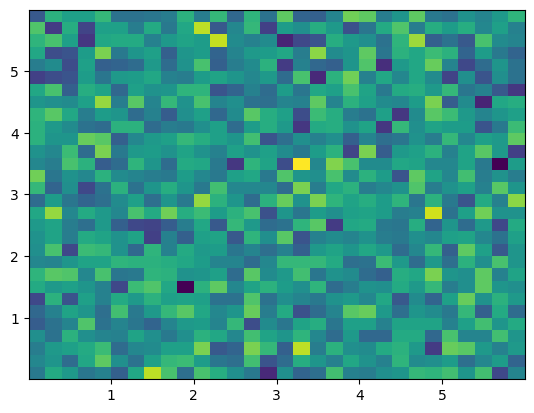

In [8]:
n_samples = 100000
samples = instance.sample(n_samples)
plt.hist2d(samples[0], samples[1], density=True, bins=bins_per_dim)
# sns.scatterplot(x=samples[0], y=integrand(samples))

In [9]:
instance.learn(n_samples)

(array([[0.        , 0.00250153, 0.00250153, 0.00250153, 0.00500306,
         0.        , 0.00500306, 0.        , 0.00750459, 0.03251991,
         0.01000612, 0.00750459, 0.01250766, 0.00250153, 0.00250153,
         0.00500306, 0.00500306, 0.00500306, 0.00500306, 0.03502144,
         0.01000612, 0.00750459, 0.01000612, 0.        , 0.        ,
         0.        , 0.00250153, 0.        , 0.00250153, 0.00250153],
        [0.00250153, 0.00250153, 0.        , 0.00500306, 0.00250153,
         0.00250153, 0.00250153, 0.01000612, 0.        , 0.02001225,
         0.02751684, 0.01000612, 0.00250153, 0.00750459, 0.00250153,
         0.        , 0.00250153, 0.00250153, 0.01000612, 0.01751072,
         0.03001837, 0.00500306, 0.        , 0.00500306, 0.00500306,
         0.        , 0.        , 0.        , 0.        , 0.00250153],
        [0.        , 0.00250153, 0.        , 0.        , 0.        ,
         0.        , 0.00250153, 0.        , 0.01000612, 0.02501531,
         0.03001837, 0.01751072,

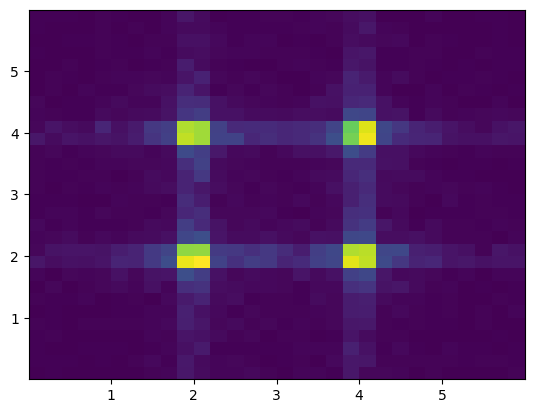

In [10]:
n_samples = 10000
samples = instance.sample(n_samples)
plt.hist2d(samples[0], samples[1], density=True, bins=bins_per_dim)

In [11]:
instance.integrate(10000)

1.943291504961629

In [12]:
res_final = []
for i in range(n_tries):
    res_final.append(instance.integrate(10000))

In [13]:
len(res_final), len(res_raw)

(1000, 1000)

In [14]:
from analysis.plot_matplotlib import plot_hist

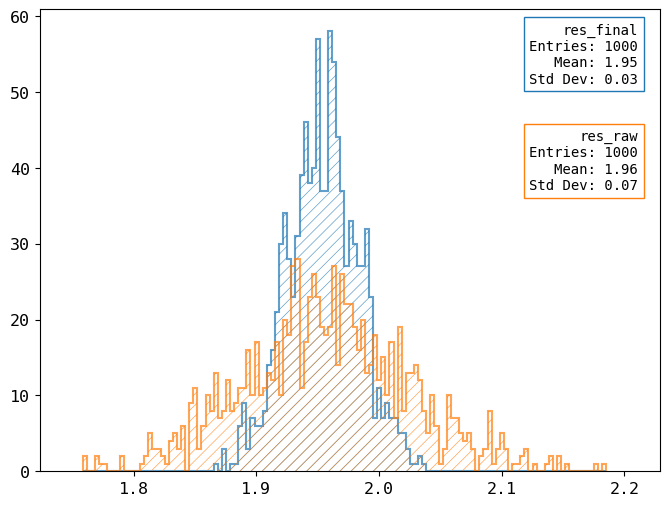

In [20]:
plot_hist(pd.DataFrame(dict(res_final=res_final, res_raw=res_raw)))

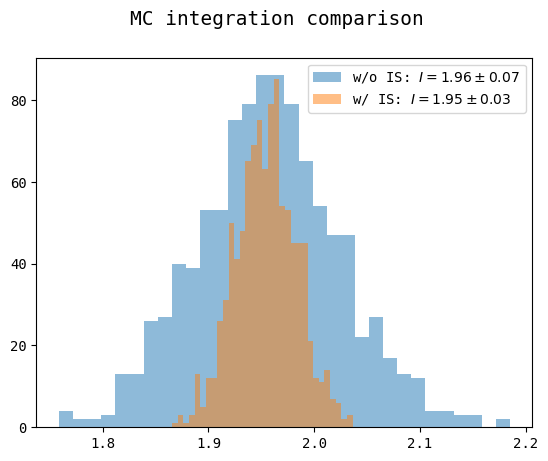

In [21]:
fig, ax = plt.subplots()

fig.suptitle('MC integration comparison', fontsize=14)
ax.hist(res_raw, bins=32, alpha = 0.5, label=rf"w/o IS: $I={np.average(res_raw):0.2f}\pm{np.std(res_raw):0.2f}$")
ax.hist(res_final, bins=32, alpha=0.5, label=rf"w/ IS: $I={np.average(res_final):0.2f}\pm{np.std(res_final):0.2f}$")
ax.legend(loc="upper right")

<Axes: >

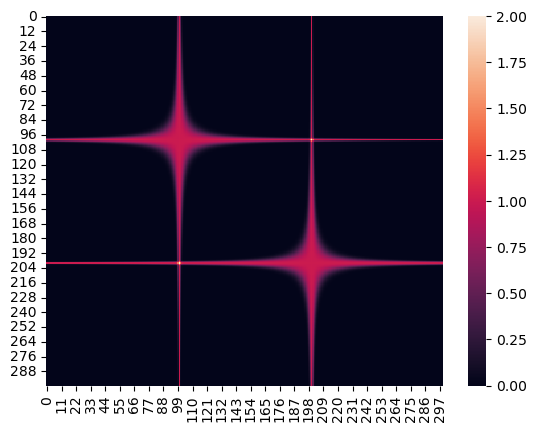

In [51]:
b = np.arange(0.0, 6.0, 0.02)
d = np.arange(0.0, 6.0, 0.02)

args = np.meshgrid(b, d)
nu = integrand(args)

sns.heatmap(nu)

In [400]:
samples, weights = instance.sample(10000, with_weights=True)

In [402]:
ind_min = np.argmin(weights)
print("Min", ind_min, weights[ind_min], samples[:, ind_min])

ind_max = np.argmax(weights)
print("Max", ind_max, weights[ind_max], samples[:, ind_max])

Min 55 6.990546907365836e-05 [0.46983202 0.06959909]
Max 1183 0.0915105921608451 [4.00575341 2.00445287]


In [411]:
indices = samples[1].argsort()

<Axes: >

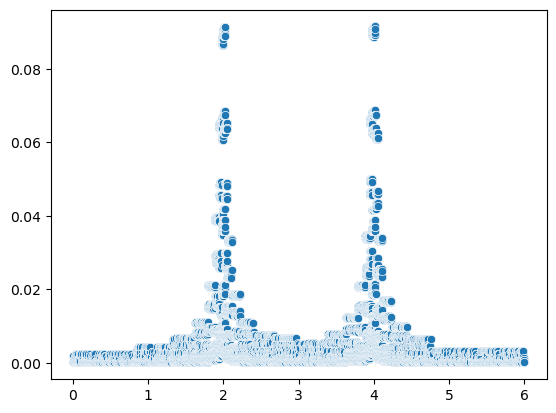

In [408]:
sns.scatterplot(x=samples[0][indices], y=weights[indices])

In [409]:
np.trapz(weights[indices], x=samples[0][indices])

0.021330042003147268

In [412]:
np.trapz(weights[indices], x=samples[1][indices])

0.02001419688623319